# Using Recommender Systems 

Student name: Jonathan Lee
Student pace: Full Time
Scheduled project review date/time: June 22, 2pm
Instructor name: James Irving
Blog post URL: 

## Overview

This project uses the Surprise package from scikit with Amazon review data of Luxury Beauty products to build a recommendation system. In this analysis, we find that out of KNN methods, Singular Value Decomposition, and Alternating Least Squares methods, Singular Value Decomposition was the best performing model for our selected data. We also examine what the optimal hyperparameters are for this particular dataset.

## Business Problem

Our client is a beauty product retailer that currently carries a small handful of Amazon's top featured brands and products. We want to optimize a recommender system based on Amazon reviews that as accurately as possible predicts other products that customers would be likely to enjoy. Using this optimized recommender system, we will move forward with the goal of using our client's customer preferences to extract insights into what other brands/products would be successful if our client were to add them to their product offering.
***
Questions to address:
* What is the best type of model to use to build a recommender system to work with this dataset?
* What are the optimal hyperparameters to use during the modeling process?
* Assuming that our client currently carries the most popular products found on Amazon, what other products can we recommend adding to inventory?
***

## Data Understanding and Preparation

In this analysis, we use Amazon review data and product metadata featured in the following paper:

**Justifying recommendations using distantly-labeled reviews and fined-grained aspects**

Jianmo Ni, Jiacheng Li, Julian McAuley


*Empirical Methods in Natural Language Processing (EMNLP), 2019*

Due to the large size of the complete dataset and hardware limitations, we will complete the analysis with only reviews and metadata from the luxury beauty product category.

Let's begin by loading in our data and doing some Exploratory Data Analysis.

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(27)

%matplotlib inline

In [2]:
# Set theme and style for plots
sns.set_theme('talk')
sns.set_style('darkgrid')

### Loading in the Data

We have two tables to work with in this analysis:
1. Review data: contains product ASIN code, user code, and the rating that user provided.
2. Product metadata which includes all product metadata including price, product name, and product images paired with ASIN codes.

In [3]:
# Load review dataset and metadata
review_df = pd.read_csv('data/Luxury_Beauty.csv', names=['asin', 'user', 'rating', 'timestamp'])
meta_df = pd.read_json('data/meta_Luxury_Beauty.json.gz', lines=True)
display(review_df, meta_df)

,asin,user,rating,timestamp
0,B00004U9V2,A1Q6MUU0B2ZDQG,2.0,1276560000
1,B00004U9V2,A3HO2SQDCZIE9S,5.0,1262822400
2,B00004U9V2,A2EM03F99X3RJZ,5.0,1524009600
3,B00004U9V2,A3Z74TDRGD0HU,5.0,1524009600
4,B00004U9V2,A2UXFNW9RTL4VM,5.0,1523923200
...,...,...,...,...
574623,B01HIQEOLO,AHYJ78MVF4UQO,5.0,1489968000
574624,B01HIQEOLO,A1L2RT7KBNK02K,5.0,1477440000
574625,B01HIQEOLO,A36MLXQX9WPPW9,5.0,1475193600
574626,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,1480896000


,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[After a long day of handling thorny situation...,,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",,,[],"4,324 in Beauty & Personal Care (","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...",{' Product Dimensions: ': '2.2 x 2.2 ...,Luxury Beauty,,NaT,$30.00,B00004U9V2,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
1,[],,[If you haven't experienced the pleasures of b...,,AHAVA Bath Salts,[],,,[],"1,633,549 in Beauty & Personal Care (",[],{' Product Dimensions: ': '3 x 3.5 x ...,Luxury Beauty,,NaT,,B0000531EN,[],[]
2,[],,"[Rich, black mineral mud, harvested from the b...",,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",[],,,[],"1,806,710 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '5.1 x 3 x ...,Luxury Beauty,,NaT,,B0000532JH,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
3,[],,[This liquid soap with convenient pump dispens...,,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10...",[],,,[],[],"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...",{' Product Dimensions: ': '2.6 x 2.6 ...,Luxury Beauty,,NaT,$15.99,B00005A77F,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Remember why you love your favorite blanket? ...,,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...",,,[],"42,464 in Beauty &amp; Personal Care (",[],{' Product Dimensions: ': '7.2 x 2.2 ...,Luxury Beauty,,NaT,$18.00,B00005NDTD,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12294,[],,"[, CND Craft Culture Collection: Patina Buckle...",,"CND Shellac Power Polish, Patina Buckle","[B003ONLAXQ, B00YDEZ9T6, B074KHRD13, B00R3PZK1...",,,[],"88,740 in Beauty & Personal Care (","[B00D2VMUA2, B074KJZJYW, B074KHRD13, B073SB9JW...","{' Item Weight: ': '0.48 ounces', 'Sh...",Luxury Beauty,,NaT,$15.95,B01HIQIEYC,[],[]
12295,[],,[CND Shellac was designed to be used as a syst...,,CND Shellac power polish denim patch,"[B003ONLAXQ, B003OH0KBA, B004LEMWGG, B01MT91G4...",,,[],"122,331 in Beauty & Personal Care (","[B00D2VMUA2, B01L0EV8X2, B004LEMWGG, B00EFGDYZ...","{'Shipping Weight:': '1.4 ounces (', 'ASIN:': ...",Luxury Beauty,,NaT,$15.95,B01HIQHQU0,[],[]
12296,[],,[CND Shellac was designed to be used as a syst...,,"CND Shellac, Leather Satchel","[B003ONLAXQ, B003OH0KBA, B004LEMWGG, B01MT91G4...",,,[],"168,028 in Beauty & Personal Care (","[B00D2VMUA2, B01L0EV8X2, B004LEMWGG, B00EFGDYZ...","{'Shipping Weight:': '1.4 ounces (', 'Domestic...",Luxury Beauty,,NaT,$15.95,B01HIQEOLO,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
12297,[],,[The I AM JUICY COUTURE girl is once again tak...,,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz...",[],,,[],"490,755 in Beauty & Personal Care (","[B0757439SY, B01HJ2UY1G, B01KX3TK7C, B01LX71LJ...",{' Product Dimensions: ': '3.3 x 2.7 ...,Luxury Beauty,,NaT,$76.00,B01HJ2UY0W,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


### Dropping Duplicates and Null Values

We are dealing with quite a large dataset, with the number of ratings being over 570,000. Therefore, it will be important to reduce the memory as much as possible by removing unnecessary features and reducing the memory usage. Since the timestamp data is unnecessary to our analysis, we will go ahead and drop that column from our ratings dataset. We also go through an initial iteration of removing duplicates and null values.

In [4]:
# Drop duplicates and timestamp column from review table
review_df.drop_duplicates(inplace=True)
review_df.drop('timestamp', axis=1, inplace=True)
review_df

,asin,user,rating
0,B00004U9V2,A1Q6MUU0B2ZDQG,2.0
1,B00004U9V2,A3HO2SQDCZIE9S,5.0
2,B00004U9V2,A2EM03F99X3RJZ,5.0
3,B00004U9V2,A3Z74TDRGD0HU,5.0
4,B00004U9V2,A2UXFNW9RTL4VM,5.0
...,...,...,...
574623,B01HIQEOLO,AHYJ78MVF4UQO,5.0
574624,B01HIQEOLO,A1L2RT7KBNK02K,5.0
574625,B01HIQEOLO,A36MLXQX9WPPW9,5.0
574626,B01HJ2UY0W,A23DRCOMC2RIXF,1.0


Similarly with our metadata, we will go ahead and slice out the ASIN code and product names, since those are the pieces of data that will be used in our analysis. Then, we go on to drop duplicates from this table as well.

In [5]:
# Slice asin and title columns from metadata table
meta_df = meta_df[['asin','title']]

In [6]:
# Drop duplicates from metadata table
meta_df.drop_duplicates(inplace=True)
meta_df

,asin,title
0,B00004U9V2,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,B0000531EN,AHAVA Bath Salts
2,B0000532JH,"AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4"
3,B00005A77F,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10..."
4,B00005NDTD,Soy Milk Hand Crme
...,...,...
12294,B01HIQIEYC,"CND Shellac Power Polish, Patina Buckle"
12295,B01HIQHQU0,CND Shellac power polish denim patch
12296,B01HIQEOLO,"CND Shellac, Leather Satchel"
12297,B01HJ2UY0W,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz..."


### Merging Data Tables

Now, we will create a catalog_df which contains all of our ratings combined with their titles. This dataframe contains all of the information we will need for the purpose of our analysis.

In [7]:
# Combine review data and metadata to create catalog table
catalog_df = review_df.merge(meta_df, how='left', on='asin')
catalog_df

,asin,user,rating,title
0,B00004U9V2,A1Q6MUU0B2ZDQG,2.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,B00004U9V2,A3HO2SQDCZIE9S,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
2,B00004U9V2,A2EM03F99X3RJZ,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
3,B00004U9V2,A3Z74TDRGD0HU,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
4,B00004U9V2,A2UXFNW9RTL4VM,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
...,...,...,...,...
538077,B01HIQEOLO,AHYJ78MVF4UQO,5.0,"CND Shellac, Leather Satchel"
538078,B01HIQEOLO,A1L2RT7KBNK02K,5.0,"CND Shellac, Leather Satchel"
538079,B01HIQEOLO,A36MLXQX9WPPW9,5.0,"CND Shellac, Leather Satchel"
538080,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz..."


In [8]:
# Drop duplicates from merged catalog table
catalog_df.drop_duplicates(inplace=True)
catalog_df

,asin,user,rating,title
0,B00004U9V2,A1Q6MUU0B2ZDQG,2.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,B00004U9V2,A3HO2SQDCZIE9S,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
2,B00004U9V2,A2EM03F99X3RJZ,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
3,B00004U9V2,A3Z74TDRGD0HU,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
4,B00004U9V2,A2UXFNW9RTL4VM,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
...,...,...,...,...
538077,B01HIQEOLO,AHYJ78MVF4UQO,5.0,"CND Shellac, Leather Satchel"
538078,B01HIQEOLO,A1L2RT7KBNK02K,5.0,"CND Shellac, Leather Satchel"
538079,B01HIQEOLO,A36MLXQX9WPPW9,5.0,"CND Shellac, Leather Satchel"
538080,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz..."


In [9]:
# Check for null values
catalog_df.isna().sum()

asin        0
user        0
rating      0
title     184
dtype: int64

Since the number of null values in this catalog dataframe are quite small, we can go ahead and remove the observations where we do not have a product name paired with its ASIN code.

In [10]:
# Drop null values
catalog_df.dropna(inplace=True)
catalog_df

,asin,user,rating,title
0,B00004U9V2,A1Q6MUU0B2ZDQG,2.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,B00004U9V2,A3HO2SQDCZIE9S,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
2,B00004U9V2,A2EM03F99X3RJZ,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
3,B00004U9V2,A3Z74TDRGD0HU,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
4,B00004U9V2,A2UXFNW9RTL4VM,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
...,...,...,...,...
538077,B01HIQEOLO,AHYJ78MVF4UQO,5.0,"CND Shellac, Leather Satchel"
538078,B01HIQEOLO,A1L2RT7KBNK02K,5.0,"CND Shellac, Leather Satchel"
538079,B01HIQEOLO,A36MLXQX9WPPW9,5.0,"CND Shellac, Leather Satchel"
538080,B01HJ2UY0W,A23DRCOMC2RIXF,1.0,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz..."


### Visualizing the Data

In this section, we will proceed to visualize the distribution of our ratings as well as how many users gave how many ratings each.

In [15]:
# Check distribution of ratings
catalog_df['rating'].value_counts().sort_index(ascending=False)

5.0    355360
4.0     65885
3.0     39428
2.0     27830
1.0     47608
Name: rating, dtype: int64

In [16]:
# Check distribution of ratings in percent
catalog_df['rating'].value_counts(normalize=True).sort_index(ascending=False)

5.0    0.662848
4.0    0.122894
3.0    0.073544
2.0    0.051911
1.0    0.088803
Name: rating, dtype: float64

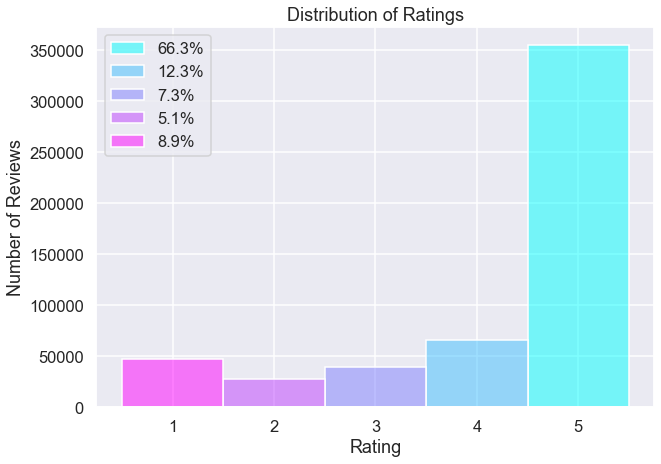

In [17]:
# Create bar plot of rating distribution
fig, ax = plt.subplots(figsize=(10,7))

g = sns.histplot(data=catalog_df, x='rating', hue='rating', palette='cool_r', discrete=True, legend=True)

ax.set_title('Distribution of Ratings')
ax.set_xlabel('Rating')
ax.set_ylabel('Number of Reviews')
ax.set_xticks([1,2,3,4,5])
ax.legend(['66.3%','12.3%','7.3%','5.1%','8.9%']);

In [18]:
# Get number of ratings per user
freq_df = catalog_df.groupby('user').agg('count').reset_index()
freq_df

,user,asin,rating,title
0,A0002708WFPIPQT73GK8,1,1,1
1,A0010876CNE3ILIM9HV0,1,1,1
2,A0026756LXIAIU5P6JUI,1,1,1
3,A0036810AKGSUKHOLV23,1,1,1
4,A004163085WKABQBPDOX,1,1,1
...,...,...,...,...
416072,AZZYUA6JI1MO0,2,2,2
416073,AZZYW4YOE1B6E,3,3,3
416074,AZZZ27Q95ZU80,1,1,1
416075,AZZZ3LGTCGUZF,1,1,1


In [19]:
freq_df.describe()

,asin,rating,title
count,416077.000000,416077.000000,416077.000000
mean,1.288490,1.288490,1.288490
std,1.130142,1.130142,1.130142
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000
max,119.000000,119.000000,119.000000


In [20]:
# Create table with number of users vs number of ratings per user
plot_df = freq_df.groupby('asin').agg('count')[:10]
plot_df

,user,rating,title
asin,,,
1,344023,344023,344023
2,52115,52115,52115
3,11409,11409,11409
4,3885,3885,3885
5,1640,1640,1640
6,825,825,825
7,464,464,464
8,601,601,601
9,269,269,269


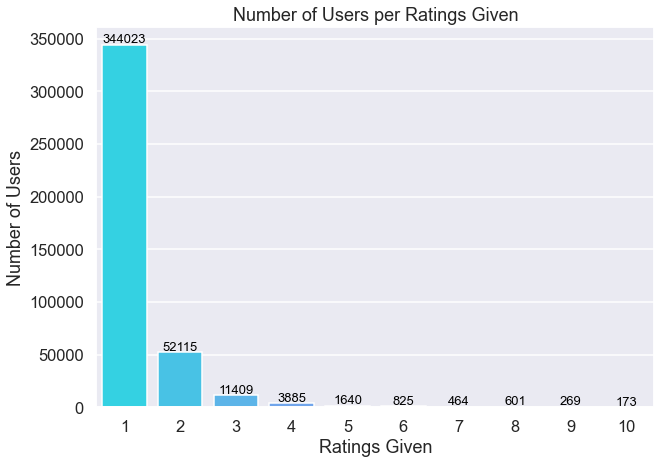

In [21]:
# Create bar plot of users per ratings given
fig, ax = plt.subplots(figsize=(10,7))

g = sns.barplot(data=plot_df, x=plot_df.index, y=plot_df['user'], palette='cool')

ax.set_title('Number of Users per Ratings Given')
ax.set_xlabel('Ratings Given')
ax.set_ylabel('Number of Users')

for p in ax.patches:
             ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=13, color='black', xytext=(0, 5),
                 textcoords='offset points');

In [22]:
# Check measures of central tendency
catalog_df.describe()

,rating
count,536111.000000
mean,4.219074
std,1.302025
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


### Data Mapping

As mentioned before, due to the large size of this dataset, it is important to reduce the data to minimize the amount of memory being used. Hence, we map our ASIN and user codes to integer values in order to optimize memory allocation during the modeling process as well as converting our data types.

In [23]:
# Create list of unique asin codes
asin_list = catalog_df['asin'].unique()

In [24]:
# Create an array of integers to map asin codes to
np.arange(len(asin_list))

array([    0,     1,     2, ..., 12108, 12109, 12110])

In [25]:
# Construct dictionary using asin and corresponding product code
asin_map = dict(zip(asin_list, np.arange(len(asin_list))))

In [26]:
# Check dictionary format
asin_map

{'B00004U9V2': 0,
 'B00005A77F': 1,
 'B00005NDTD': 2,
 'B00005V50C': 3,
 'B00005V50B': 4,
 'B000066SYB': 5,
 'B000068DWY': 6,
 'B00008WFSM': 7,
 'B0000Y3NO6': 8,
 'B0000ZREXG': 9,
 'B0000ZREXQ': 10,
 'B00011JU6I': 11,
 'B00011QUKW': 12,
 'B00012C5RS': 13,
 'B000142FVW': 14,
 'B000141PIG': 15,
 'B00014351Q': 16,
 'B0001433OU': 17,
 'B000141PYK': 18,
 'B00014340I': 19,
 'B0001435D4': 20,
 'B00014353E': 21,
 'B0001432PK': 22,
 'B00014GT8W': 23,
 'B0001EKVCW': 24,
 'B0001EKVGS': 25,
 'B0001EKTTC': 26,
 'B0001EL5KO': 27,
 'B0001EL5JA': 28,
 'B0001EL9BO': 29,
 'B0001EL0WC': 30,
 'B0001EL5OU': 31,
 'B0001EL59K': 32,
 'B0001EL5R2': 33,
 'B0001EL4DC': 34,
 'B0001EL39C': 35,
 'B0001EL5Q8': 36,
 'B0001EL4M8': 37,
 'B0001EKYEM': 38,
 'B0001F3QV4': 39,
 'B0001NAYOI': 40,
 'B0001QNLNG': 41,
 'B0001UWRCI': 42,
 'B0001XDU2Q': 43,
 'B0001XDTYA': 44,
 'B0001XDUBC': 45,
 'B0001XDTWM': 46,
 'B0001Y74TA': 47,
 'B0001Y74TU': 48,
 'B0001Y74XG': 49,
 'B0001Y74H2': 50,
 'B0001Y74KO': 51,
 'B0001Y74SG': 52,
 'B

In [27]:
# Map asin to product code integer and check
catalog_df['asin'] = catalog_df['asin'].map(asin_map)
catalog_df

,asin,user,rating,title
0,0,A1Q6MUU0B2ZDQG,2.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,0,A3HO2SQDCZIE9S,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
2,0,A2EM03F99X3RJZ,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
3,0,A3Z74TDRGD0HU,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
4,0,A2UXFNW9RTL4VM,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
...,...,...,...,...
538077,6007,AHYJ78MVF4UQO,5.0,"CND Shellac, Leather Satchel"
538078,6007,A1L2RT7KBNK02K,5.0,"CND Shellac, Leather Satchel"
538079,6007,A36MLXQX9WPPW9,5.0,"CND Shellac, Leather Satchel"
538080,12109,A23DRCOMC2RIXF,1.0,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz..."


In [28]:
# Rename 'asin' column to 'product_code'
catalog_df = catalog_df.rename(columns={'asin': 'product_code'})

In [29]:
# Create list of unique users
user_list = catalog_df['user'].unique()

In [30]:
# Create an array of integers to map user codes to
np.arange(len(user_list))

array([     0,      1,      2, ..., 416074, 416075, 416076])

In [31]:
# Construct dictionary using user code and corresponding integer
user_map = dict(zip(user_list, np.arange(len(user_list))))

In [32]:
# Check dictionary format
user_map

{'A1Q6MUU0B2ZDQG': 0,
 'A3HO2SQDCZIE9S': 1,
 'A2EM03F99X3RJZ': 2,
 'A3Z74TDRGD0HU': 3,
 'A2UXFNW9RTL4VM': 4,
 'AXX5G4LFF12R6': 5,
 'A7GUKMOJT2NR6': 6,
 'A3FU4L59BHA9FY': 7,
 'A1AMNMIPQMXH9M': 8,
 'A3DMBDTA8VGWSX': 9,
 'A160DTI3H7VHLQ': 10,
 'A1H41DKPDPVA0R': 11,
 'A2BDI7THUMJ8V': 12,
 'AM7EBP5TRX7AC': 13,
 'A31FOVCS3WTWPT': 14,
 'AXUU8F9EM6U3E': 15,
 'A24B46V78ATNRP': 16,
 'ABUBKML2EONCG': 17,
 'A2UA6E1RVG3C1I': 18,
 'A1TRMJHEDGX0HF': 19,
 'A2TTJS62322SXW': 20,
 'AX2K33SNI3WHN': 21,
 'ALX99DYO827ZK': 22,
 'A3PVVQ9MHYFTV9': 23,
 'A22NEUQTKWQM98': 24,
 'A1TQQZ6NVDTPNL': 25,
 'A32E3RVLI6D4TM': 26,
 'A3KUYXBMJ8AVIX': 27,
 'A3TMPSQ7X4M9LO': 28,
 'AUEUNR2AQQ0SY': 29,
 'A2P5MRZ68JX8EE': 30,
 'A8VD1E2O6N2KO': 31,
 'A1Q3N7GU27KGMA': 32,
 'A3QEV9GSI4HPA5': 33,
 'A2FMDHT0HNA3WY': 34,
 'A2QPHVVXS9FUBS': 35,
 'AL63CNA6X6IX8': 36,
 'A2N6AACMA6WOMN': 37,
 'A35I4FD5EARKTS': 38,
 'A2N8V79LWVR8F2': 39,
 'A2R9R1DJ9RHXOX': 40,
 'A60EV0X26JNB3': 41,
 'A3CG9DJUY5F2UY': 42,
 'AEDOSTGV48XO9': 43,
 'A21BQWP17Y

In [33]:
# Map asin to product code integer and check
catalog_df['user'] = catalog_df['user'].map(user_map)
catalog_df

,product_code,user,rating,title
0,0,0,2.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
1,0,1,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
2,0,2,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
3,0,3,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
4,0,4,5.0,Crabtree &amp; Evelyn - Gardener's Ultra-Moist...
...,...,...,...,...
538077,6007,194409,5.0,"CND Shellac, Leather Satchel"
538078,6007,175285,5.0,"CND Shellac, Leather Satchel"
538079,6007,416075,5.0,"CND Shellac, Leather Satchel"
538080,12109,416076,1.0,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz..."


In [34]:
# Convert to more efficient integer types
catalog_df['rating']=catalog_df['rating'].astype(np.int8)
catalog_df['product_code']=catalog_df['product_code'].astype(np.int32)
catalog_df['user']=catalog_df['user'].astype(np.int32)

In [35]:
# Check data types
catalog_df.dtypes

product_code     int32
user             int32
rating            int8
title           object
dtype: object

In [11]:
# Check datatype of columns
catalog_df.dtypes

asin       object
user       object
rating    float64
title      object
dtype: object

### Slicing Data for Modeling

We're almost ready to enter the modeling process, so let's go ahead and slice out just the columns we need to do so.

In [36]:
# Create dataframe with user item rating
df = catalog_df[['user', 'product_code', 'rating']]

In [37]:
# Save csv file to use in Databricks ALS model
# catalog_df.to_csv(r'data/Luxury_Beauty_reduced.csv', index=False)

## Data Modeling

In this section, we will take a look at using the Surprise scikit package to test which algorithm will be the best for building a recommender system using our Amazon review data.

The models we will look at are some K-Nearest Neighbor models and a series of gridsearched Singular Value Decomposition models. You can find the process behind modeling using Alternating Least Squares in PySpark, but we will leave this model out of our main analysis due to its poor performance on this specific dataset as well as the fact that we will need to use PySpark to perform the modeling process.

In [38]:
# If using Colab, install Surprise
# %pip install scikit-surprise

In [39]:
# Import necessary packages for building recommender system
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine, msd, pearson
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

In [40]:
# Create reader object and format review data for processing
reader = Reader(line_format = 'user item rating', sep = ',')
data = Dataset.load_from_df(df, reader=reader)

In [41]:
# Create train test split
trainset, testset = train_test_split(data, test_size=0.25, random_state=27)

### KNN Basic

Before training our KNN models, we want to know how many unique values there are for items and users in order to determine which feature would be most efficient to calculate difference between. We will select the feature that has less unique values, which is the number of items as we will see.

In [12]:
# Check how many unique values for asin
catalog_df['asin'].nunique()

12111

In [14]:
# Check how many unique values for user
catalog_df['user'].nunique()

416077

In [42]:
# KNN Basic with cosine similarity
KNN_basic_cos = knns.KNNBasic(sim_options={'name': 'cosine', 
                                          'user_based': False}).fit(trainset)
cross_validate(KNN_basic_cos, data, verbose= True, n_jobs=-1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2632  1.2684  1.2633  1.2602  1.2582  1.2627  0.0035  
MAE (testset)     0.9401  0.9429  0.9395  0.9383  0.9365  0.9395  0.0021  
Fit time          17.17   17.33   16.48   12.83   11.38   15.04   2.45    
Test time         3.62    2.55    2.01    1.48    1.01    2.13    0.90    


{'test_rmse': array([1.26322435, 1.2683995 , 1.26330598, 1.2601787 , 1.25821732]),
 'test_mae': array([0.94014167, 0.94290605, 0.93953202, 0.93834403, 0.93647552]),
 'fit_time': (17.165947198867798,
  17.326600074768066,
  16.484190225601196,
  12.827233076095581,
  11.379620790481567),
 'test_time': (3.6169238090515137,
  2.5465028285980225,
  2.0098717212677,
  1.4813041687011719,
  1.0089759826660156)}

In [43]:
# KNN Basic with pearson correlation similarity
KNN_basic_pearson = knns.KNNBasic(sim_options={'name': 'pearson', 
                                              'user_based': False}).fit(trainset)
cross_validate(KNN_basic_pearson, data, verbose= True, n_jobs=-1)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2612  1.2494  1.2628  1.2675  1.2569  1.2596  0.0061  
MAE (testset)     0.9569  0.9504  0.9583  0.9623  0.9552  0.9566  0.0039  
Fit time          16.67   18.04   16.93   14.47   13.50   15.92   1.67    
Test time         2.51    1.84    1.66    1.65    1.27    1.79    0.41    


{'test_rmse': array([1.26120969, 1.24943058, 1.26283388, 1.26754131, 1.25687472]),
 'test_mae': array([0.95694535, 0.95038497, 0.95833556, 0.96234921, 0.95516655]),
 'fit_time': (16.669835090637207,
  18.041382789611816,
  16.928279161453247,
  14.473177909851074,
  13.500527143478394),
 'test_time': (2.511523962020874,
  1.8356692790985107,
  1.6648190021514893,
  1.6476941108703613,
  1.268345832824707)}

### KNN With Means

In [44]:
# KNN with Means with cosine similarity
KNN_mean_cos = knns.KNNWithMeans(sim_options={'name': 'cosine', 'user_based': False}).fit(trainset)
cross_validate(KNN_mean_cos, data, verbose= True, n_jobs=-1)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2635  1.2616  1.2630  1.2581  1.2585  1.2609  0.0023  
MAE (testset)     0.9441  0.9444  0.9443  0.9425  0.9421  0.9435  0.0010  
Fit time          12.52   14.74   14.50   12.35   11.31   13.09   1.32    
Test time         4.08    1.96    1.53    1.38    1.23    2.04    1.05    


{'test_rmse': array([1.26353617, 1.26155318, 1.26295602, 1.25806818, 1.25848398]),
 'test_mae': array([0.94411476, 0.94443751, 0.94429647, 0.94253575, 0.94209396]),
 'fit_time': (12.519986867904663,
  14.743391990661621,
  14.504050970077515,
  12.354866027832031,
  11.310466051101685),
 'test_time': (4.082274913787842,
  1.9620540142059326,
  1.5310900211334229,
  1.3792190551757812,
  1.2327818870544434)}

In [45]:
# KNN with Means with pearson correlation similarity
KNN_mean_pearson = knns.KNNWithMeans(sim_options={'name': 'pearson', 'user_based': False}).fit(trainset)
cross_validate(KNN_mean_pearson, data, verbose= True, n_jobs=-1)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2587  1.2616  1.2565  1.2576  1.2662  1.2601  0.0035  
MAE (testset)     0.9545  0.9561  0.9531  0.9522  0.9599  0.9551  0.0027  
Fit time          22.76   20.54   19.36   17.46   16.30   19.28   2.28    
Test time         1.83    2.15    1.78    1.84    1.43    1.81    0.23    


{'test_rmse': array([1.25871611, 1.26155307, 1.25654958, 1.25755658, 1.26615351]),
 'test_mae': array([0.95446218, 0.95605427, 0.95305145, 0.95218445, 0.95985022]),
 'fit_time': (22.764894008636475,
  20.536811113357544,
  19.361613750457764,
  17.462013006210327,
  16.2983820438385),
 'test_time': (1.8285608291625977,
  2.146353244781494,
  1.7847669124603271,
  1.842088222503662,
  1.43076491355896)}

### KNN With Z-Score

In [46]:
# KNN with Z-score with pearson baseline correlation similarity
KNN_z_pearson = knns.KNNWithZScore(sim_options={'name': 'pearson_baseline', 'user_based': False}).fit(trainset)
cross_validate(KNN_z_pearson, data, verbose= True, n_jobs=-1)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithZScore on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2555  1.2566  1.2563  1.2693  1.2604  1.2596  0.0051  
MAE (testset)     0.9466  0.9488  0.9487  0.9563  0.9505  0.9502  0.0033  
Fit time          13.55   14.60   13.15   13.91   11.24   13.29   1.13    
Test time         2.24    1.54    2.38    1.03    1.17    1.67    0.55    


{'test_rmse': array([1.2555194 , 1.25657864, 1.25633644, 1.26925501, 1.26040508]),
 'test_mae': array([0.94655318, 0.94882369, 0.94870317, 0.95634638, 0.95052545]),
 'fit_time': (13.553286075592041,
  14.600893020629883,
  13.150964975357056,
  13.91170883178711,
  11.235476016998291),
 'test_time': (2.2439839839935303,
  1.538593053817749,
  2.3798420429229736,
  1.0316739082336426,
  1.1739749908447266)}

### KNN Baseline

In [47]:
# KNN Baseline with pearson baseline similarity
KNN_base_pearson= knns.KNNBaseline(sim_options={'name': 'pearson_baseline', 'user_based': False}).fit(trainset)
cross_validate(KNN_base_pearson, data, verbose= True, n_jobs=-1)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2227  1.2217  1.2241  1.2254  1.2270  1.2242  0.0019  
MAE (testset)     0.9114  0.9096  0.9111  0.9130  0.9117  0.9114  0.0011  
Fit time          18.01   22.43   21.47   19.48   18.33   19.94   1.74    
Test time         5.95    1.97    1.60    2.46    1.26    2.65    1.70    


{'test_rmse': array([1.22267553, 1.22173688, 1.22414958, 1.22538799, 1.22703904]),
 'test_mae': array([0.91141176, 0.90962671, 0.91110502, 0.91299398, 0.91167086]),
 'fit_time': (18.00750994682312,
  22.43341374397278,
  21.469024896621704,
  19.481950283050537,
  18.32690405845642),
 'test_time': (5.952499866485596,
  1.9701628684997559,
  1.6023647785186768,
  2.4593660831451416,
  1.264455795288086)}

We can see that the RMSE scores for our KNN are similar across the board, except for the KNN Baseline model, which did have a slightly lower score.

### Singular Value Decomposition

Now, let's move onto the SVD model where we will begin with a basic model and try to improve our score by using a series of gridsearches.

In [48]:
# Train basic SVD model
svd = SVD(random_state=27)
svd.fit(trainset)

In [49]:
# Get predictions on test data and print RMSE
predictions= svd.test(testset)
print(accuracy.rmse(predictions), accuracy.mae(predictions))

RMSE: 1.2343
MAE:  0.9513
1.2343058409785395 0.9513405014854374


In [50]:
# Gridsearch #1
param_grid = {'n_factors':[110, 130],'n_epochs': [25, 30], 'lr_all': [0.025, 0.05],
              'reg_all': [0.1, 0.2]}
svd_grid1 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, n_jobs=-1)
svd_grid1.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 15.8min finished


In [51]:
# Print results from gridsearch #1
svd_grid1.best_params

{'rmse': {'n_factors': 130, 'n_epochs': 30, 'lr_all': 0.025, 'reg_all': 0.1},
 'mae': {'n_factors': 110, 'n_epochs': 30, 'lr_all': 0.05, 'reg_all': 0.1}}

In [52]:
# Use best params to get RMSE and MAE on test data
svd = SVD(n_factors=130, n_epochs=30, lr_all=0.025, reg_all=0.1, random_state=27)
svd.fit(trainset)
predictions = svd.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 1.2182
MAE:  0.9285


0.9285218562243839

In [53]:
# Gridsearch #2
param_grid = {'n_factors':[130, 150],'n_epochs': [30, 40], 'lr_all': [0.01, 0.025],
              'reg_all': [0.05, 0.1]}
svd_grid2 = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, n_jobs=-1)
svd_grid2.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 22.4min finished


In [54]:
# Print results from gridsearch #2
svd_grid2.best_params

{'rmse': {'n_factors': 130, 'n_epochs': 40, 'lr_all': 0.025, 'reg_all': 0.1},
 'mae': {'n_factors': 130, 'n_epochs': 40, 'lr_all': 0.025, 'reg_all': 0.05}}

In [55]:
# Use best params to get RMSE and MAE on test data
svd = SVD(n_factors=150, n_epochs=40, lr_all=0.025, reg_all=0.1, random_state=27)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 1.2174
1.217377443190885
MAE:  0.9259
0.9258506393305158


In [56]:
# Gridsearch #3
param_grid = {'n_factors':[150, 200],'n_epochs': [40, 50], 'lr_all': [0.025],
              'reg_all': [0.1]}
svd_grid_final = GridSearchCV(SVD,param_grid=param_grid,joblib_verbose=5, n_jobs=-1)
svd_grid_final.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  6.0min remaining:  6.0min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  6.7min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  8.5min finished


In [57]:
# Print results from final gridsearch
svd_grid_final.best_params

{'rmse': {'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.025, 'reg_all': 0.1},
 'mae': {'n_factors': 150, 'n_epochs': 50, 'lr_all': 0.025, 'reg_all': 0.1}}

In [58]:
# Use best params to get RMSE and MAE on test data
svd = SVD(lr_all=0.025, n_epochs=50, n_factors=150, reg_all=0.1, random_state=27)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 1.2171
1.2171440876076423
MAE:  0.9237
0.9237444509387739


Great! We can see that by using our gridsearches, we were able to make some improvements in the RMSE score between iterations. It also looks like our SVD model has a lower RMSE score than even our best performing KNN Baseline model, so we will move forward to building our recommender system using the SVD model with the best parameters found in our final gridsearch.

## Evaluation

In this section, we will build some functions to assist the client in looking up product codes, as well as building a recommender system that takes a list of preferred products and returns a list of items that the user would likely give a high rating to.

### Searching Product Codes

Here, we create a reduced catalog of product names with their corresponding product codes. We then build a function to search the name of a product to assist our user in looking up product codes to input into the recommender system.

In [59]:
# Set pandas options to increase max column width and row number
pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 500
catalog_df

,product_code,user,rating,title
0,0,0,2,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
1,0,1,5,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
2,0,2,5,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
3,0,3,5,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
4,0,4,5,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
...,...,...,...,...
538077,6007,194409,5,"CND Shellac, Leather Satchel"
538078,6007,175285,5,"CND Shellac, Leather Satchel"
538079,6007,416075,5,"CND Shellac, Leather Satchel"
538080,12109,416076,1,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz., perfume for women"


In [60]:
lookup_df = catalog_df.drop_duplicates('product_code')
lookup_df = lookup_df[['product_code', 'title']]
lookup_df

,product_code,title
0,0,Crabtree &amp; Evelyn - Gardener's Ultra-Moisturising Hand Therapy Pump - 250g/8.8 OZ
559,1,"Crabtree &amp; Evelyn Hand Soap, Gardeners, 10.1 fl. oz."
567,2,Soy Milk Hand Crme
637,3,Supersmile Powdered Mouthrinse
653,4,"Supersmile Professional Teeth Whitening Toothpaste Recommended By Cosmetic Dentists, CLINICALLY..."
...,...,...
538039,12106,"St. Tropez Self Tan Bronzing Mousse, 8 fl. oz. &amp; Applicator Mitt Bundle"
538040,12107,Klorane Conditioner with Pomegranate - Color-Treated Hair
538064,12108,"CND Shellac, Brick Knit"
538080,12109,"Juicy Couture I Love Juicy Couture, 1.7 fl. Oz., perfume for women"


In [61]:
# Create function to look up product codes
def product_search():
    """
    Prompts user to look up product name and returns product code.

    Args:
        
    Returns:
        search_results (DataFrame) : DataFrame including results of searched 
        product name
    """
    
    # Prompt user for item name
    query_product = input('Search a brand or product: ')
    
    # Prompt user for number of results desired
    num_results = int(input('Up to how many results would you like to see? '))
    
    # Slice catalog_df to return DataFrame with results containing query
    search_results = lookup_df[lookup_df['title'].str\
                            .contains(query_product, case=False, na=False)]\
                            .head(num_results)
    
    return search_results

In [63]:
# Look up sample product codes
product_search()

Search a brand or product: vichy
Up to how many results would you like to see? 10


,product_code,title
25463,148,"Vichy Nutrilogie 2 Intense Moisturizer for Very Dry Skin, 1.69 Fl. Oz."
25974,151,"Vichy Mineralizing Thermal Water Rich in 15 Minerals, 5.1 Fl. Oz"
104528,760,"Vichy Dermafinish Setting Powder, 0.99 Oz."
104661,764,Vichy Puret&eacute; Thermale One Step Micellar Cleansing Water
116155,890,"Vichy Capital Idal Soleil Moisturizing Self Tanner Milk, 3.38 Fl. Oz."
116454,893,"Vichy Puret Thermale One Step Cleanser for Sensitive Skin, 3.3 Fl. Oz."
125527,1035,Vichy Aqualia Thermal Rich Cream Moisturizer
125530,1036,"Vichy Normaderm Hyalu Targeted Acne Treatment with Salicylic Acid, 0.5 Fl. Oz."
129240,1097,"Vichy Homme Soothing After Shave Balm, 2.53 Fl. Oz."
129622,1105,"Vichy Homme Anti-Irritation Shaving Gel, 150 ml"


### Building the Recommender System

In this section, we will take the hyperparameters from our best performing SVD model to build a usable recommender system. Upon running the function, the user will be prompted to enter a list of product codes of products that they gave high ratings to, and they will be given a list of products that our algorithm would recommend.

In [64]:
# Check last user number
df['user'].sort_values().tail()

538073    416072
538074    416073
538075    416074
538079    416075
538080    416076
Name: user, dtype: int32

In [65]:
# Create function to train model on full dataset and return recommendations
def user_ratings(lr_all=0.025, n_epochs=50, n_factors=150, reg_all=0.1, random_state=27):
    """
    Prompts user to enter customer's preferred product codes, models SVD
    using ideal hyperparameters, and returns however many predictions
    the user requests.

    Args:
        lr_all : The learning rate for all parameters. Default is ``0.025``.
        n_epochs : The number of iteration of the SGD procedure. Default is 
            ``50``.
        n_factors : The number of factors. Default is ``150``.
        reg_all : The regularization term for all parameters. Default is 
            ``0.1``.
        random_state (int) : Determines the RNG that will be used for 
            initialization. If int, ``random_state`` will be used as a seed 
            for a new RNG. This is useful to get the same initialization over 
            multiple calls to ``fit()``.  If RandomState instance, this same 
            instance is used as RNG. If ``None``, the current RNG from numpy 
            is used.  Default is``27``.
        
    Returns:
        rec_list (DataFrame) : DataFrame recommendations based on new user's
        preferred products.
    """
    
    # Prompt user for list of product codes
    list_of_products = [int(x) for x in \
                        input('Enter product codes preferred by customer (separate by spaces): ').split()]
    
    # Prompt user for desired number of product recommendations
    num_res = int(input('How many recommendations would you like? '))
    
    # Create list of ratings to add to dataset
    my_ratings = []
    for product in list_of_products:
        my_ratings.append({'user': 600000, 'product_code': product, \
                           'rating': '5'})
    
    # Add new ratings to full dataset
    new_ratings_df = df.append(my_ratings,ignore_index=True)
    
    # Format dataset for modeling
    reader = Reader(line_format='item user rating')
    new_data = Dataset.load_from_df(new_ratings_df,reader)
    
    # Train model on full dataset using preset hyperparameters
    svd_ = SVD(lr_all=lr_all, n_epochs=n_epochs, n_factors=n_factors, \
               reg_all=reg_all, random_state=random_state)
    svd_.fit(new_data.build_full_trainset())
    
    # Create total list of predictions for new user
    list_of_predictions = []
    for item in df['product_code'].unique():
        list_of_predictions.append((item, svd_.predict(600000, item)[3]))
    
    # Sort predictions from high to low
    ranked_predictions = sorted(list_of_predictions, key=lambda x:x[1], \
                                reverse=True)
    
    # Create dataframe from ranked predictions
    ranked_df = pd.DataFrame(ranked_predictions, columns=['product_code', \
                                                          'rating'])
    
    # Merge predictions with lookup df to get product names
    merged_df = ranked_df.merge(lookup_df, how='inner', on='product_code')
    
    # Create dataframe with requested number of results
    rec_list = merged_df.head(num_res)
    
    
    
    return rec_list

In [66]:
user_ratings()

Enter product codes preferred     by customer (separate by spaces): 148 151 760 764
How many recommendations would you like? 10


,product_code,rating,title
0,2,5.0,Soy Milk Hand Crme
1,28,5.0,"PCA SKIN Protecting Hydrator Broad Spectrum SPF 30, 1.7 oz."
2,35,5.0,"jane iredale So-Bronze, Bronzing Powder, 0.35 oz"
3,61,5.0,"Borghese Cura-C Anhydrous Vitamin C Treatment, 1.7 oz."
4,69,5.0,LORAC Oil-Free Wet/Dry Powder
5,87,5.0,"NEOVA Day Therapy SPF 30, 1.7 Fl Oz"
6,116,5.0,"Jurlique Moisture Replenishing Day Cream, 4.3 oz"
7,147,5.0,"Kneipp Lavender Mineral Bath Salt, Relaxing, 17.63 fl. oz."
8,161,5.0,"Pureology Hydrate Shampoo, 64 Fluid Ounce"
9,167,5.0,"Paul Mitchell Super Clean Extra Finishing Spray Firm Style Unisex, 3.5 Ounce"


In [ ]:
# View top 10 products with most reviews
top_series = catalog_df['product_code'].value_counts().head(10)
top_df = pd.DataFrame(top_series)
top_df

In [ ]:
# Create list of top 10 products with most reviews
top_list = catalog_df['product_code'].value_counts().index[:10].tolist()
top_list

In [ ]:
# Merge top_df with lookup_df
new_df = top_df.merge(lookup_df, how='left', left_index=True, right_on='product_code')
new_df

In [ ]:
new_df.set_index('product_code')

In [ ]:
user_ratings()

In [ ]:
user_ratings()

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***